In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from scipy.stats import pearsonr, spearmanr, fisher_exact, mannwhitneyu, ttest_ind

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

from matplotlib.pyplot import rc_context
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
sys.path.append('../../Code/')
from utils import read_dataset_log
import pickle as pkl
import matplotlib.gridspec as gridspec

In [2]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
label_fontsize = 10
tick_fontsize = 8

In [3]:
figdir = '../../Figures/Components'

In [4]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [5]:
gep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))

In [88]:
lineage_geps = gep_info[gep_info['Class']=='Lineage']['Short_Name'].tolist()

In [89]:
lineage_geps

['CD8-EM',
 'MAIT',
 'Treg',
 'CD4-Naive',
 'TEMRA',
 'CD4-CM',
 'gdT',
 'Th22',
 'Th17-Resting',
 'Th2-Resting',
 'Th1-Like',
 'CD8-Naive',
 'CD8-Trm',
 'Tfh-2',
 'Tph',
 'Tfh-1']

In [6]:
geps = ['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22', 'Th2-Activated', 'Th17-Activated']


In [7]:
gep_paths = read_dataset_log('cGEP Paths')
Z_spec = pd.read_csv(gep_paths['scores_spectra'][0], index_col = 0, sep = '\t')
Z_spec.index = Z_spec.index.map(rename_map)

In [8]:
top_markers = {}
marker_genes = []
for g in geps:
    marker_genes += list(Z_spec.loc[g, :].sort_values(ascending = False).head(50).index)
    top_markers[g] = list(Z_spec.loc[g, :].sort_values(ascending = False).head(50).index)
    
marker_genes += ['TBX21', 'FOXP3', 'GATA3', 'RORC', 'CCR4', 'CCR6', 'CXCR3', 
                'AHR', 'IL4', 'IL5', 'IL13', 'IL17A', 'IL17F', 'IFNG']

marker_genes = sorted(set(marker_genes))

In [9]:
marker_adts = ['AB_CD194', 'AB_CD195', 'AB_CD4', 'AB_CD8']

# COMBAT

In [ ]:
min_cells = 20

In [165]:
ms_adt_dict.values()

dict_values([['AB_CD195'], ['AB_CD194'], ['AB_CD194'], ['AB_CD25', 'AB_CD39'], ['AB_CD45RA'], ['AB_CD8', 'AB_CD45RO'], ['AB_TCR-Vd2']])

In [700]:


marker_genes = []

for vs in ms_rna_dict.values():
    marker_genes += vs

marker_genes = sorted(set(marker_genes))




marker_adts = []

for vs in ms_adt_dict.values():
    marker_adts += vs

marker_adts = sorted(set(marker_adts))

In [701]:
marker_genes, marker_adts

(['ANXA1',
  'AQP3',
  'ATP1B1',
  'B2M',
  'BTG1',
  'CCL2',
  'CCL5',
  'CCR4',
  'CCR5',
  'CCR6',
  'CD160',
  'CD2',
  'CD40LG',
  'CFH',
  'CLDND1',
  'CMC1',
  'CRTAM',
  'CST7',
  'CTLA4',
  'CXCR3',
  'CYB561',
  'DTHD1',
  'DUSP2',
  'EOMES',
  'FCGR3A',
  'FOXP3',
  'FXYD2',
  'GATA3',
  'GBP5',
  'GNLY',
  'GZMB',
  'GZMH',
  'GZMM',
  'HOPX',
  'IGFBP3',
  'IL10',
  'IL10RA',
  'IL10RB',
  'IL2',
  'IL2RA',
  'IL3',
  'IL32',
  'IL7R',
  'ITGA1',
  'ITGA4',
  'ITGAE',
  'ITM2B',
  'KIR2DL3',
  'KIR3DL2',
  'KLRC2',
  'KLRF1',
  'KLRG1',
  'LYAR',
  'LYST',
  'MS4A1',
  'MYBL1',
  'NCR1',
  'NSG1',
  'PARP8',
  'PDE4B',
  'PDE4D',
  'PERP',
  'PLCB1',
  'PRF1',
  'PTGDR2',
  'PTGER2',
  'PTPN13',
  'RORC',
  'SH2D1A',
  'STOM',
  'TIMP1',
  'TNF',
  'TRADD',
  'TRDC',
  'TRDV1',
  'TRDV2',
  'TRGC1',
  'TXNIP',
  'TYROBP',
  'XCL1',
  'ZFP36L2',
  'ZNF683'],
 ['AB_CD103',
  'AB_CD194',
  'AB_CD195',
  'AB_CD244',
  'AB_CD25',
  'AB_CD39',
  'AB_CD45RA',
  'AB_CD45RO',
  'AB

In [702]:
geps = ['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22', 'Th2-Activated', 'Th17-Activated', 
                    'Cytotoxic', 'CD8-EM', 'TEMRA', 'gdT', 'CD8-Trm']

In [ ]:
summary = []
for dataset in ['COMBAT']: #, 'Sparks', 'UK-Covid', ' AMP-RA']:
    usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
    usage.columns = usage.columns.map(rename_map)
    usage_norm = usage.div(usage.sum(axis=1), axis=0)
    X = usage_norm[geps]
    X['Dataset'] = dataset
    gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
    X['gating'] = gating.loc[X.index]
    expr_fn = params.loc[dataset, 'raw_counts_filt_fn']
    adata = sc.read(expr_fn)
    adata_RNA = adata[:, adata.var['feature_types'] == 'Gene Expression']
    adata_ADT = adata[:, adata.var['feature_types'] == 'Antibody Capture']
    # meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')

    ind = sorted(set(X.index).intersection(adata.obs.index))
    X = X.loc[ind, :]

    X['individual'] = adata_RNA.obs.loc[X.index, params.loc[dataset, 'individual_col']]
    # X['sample'] = meta.loc[X.index, params.loc[dataset, 'sample_col']]
    X['sample'] = adata.obs.loc[X.index, params.loc[dataset, 'sample_col']]    
    X['N'] = np.array(adata_RNA[X.index, :].X.sum(axis=1)).reshape(-1)

    marker_genes_filt = sorted(set(marker_genes).intersection(adata_RNA.var.index))
    print(sorted(set(marker_genes).difference(adata_RNA.var.index)))
    X[marker_genes_filt] = adata_RNA[ind, marker_genes_filt].X.todense()

    X['N_ADT'] = np.array(adata_ADT[X.index, :].X.sum(axis=1)).reshape(-1)
    marker_adts_filt = sorted(set(marker_adts).intersection(adata_ADT.var.index))
    print(sorted(set(marker_adts_filt).difference(adata_ADT.var.index)))
    X[marker_adts_filt] = adata_ADT[ind, marker_adts_filt].X.todense()

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [703]:
    marker_genes_filt = sorted(set(marker_genes).intersection(adata_RNA.var.index))
    print(sorted(set(marker_genes).difference(adata_RNA.var.index)))
    X[marker_genes_filt] = adata_RNA[ind, marker_genes_filt].X.todense()

    X['N_ADT'] = np.array(adata_ADT[X.index, :].X.sum(axis=1)).reshape(-1)
    marker_adts_filt = sorted(set(marker_adts).intersection(adata_ADT.var.index))
    print(sorted(set(marker_adts_filt).difference(adata_ADT.var.index)))
    X[marker_adts_filt] = adata_ADT[ind, marker_adts_filt].X.todense()

[]
[]


In [263]:
gep_list

['CD8-EM', 'Th1-Like', 'TEMRA', 'Th17-Resting', 'Treg']

In [242]:
marker_adts_filt

['AB_CD194',
 'AB_CD195',
 'AB_CD25',
 'AB_CD39',
 'AB_CD4-2',
 'AB_CD45RA',
 'AB_CD45RO',
 'AB_CD8']

In [653]:
thresh = 0.1#0.0625

for g in geps:
    X['Bin_%s' % g] = X[g]>thresh

In [344]:
cd4_gates = ['CD4_Naive', 'Treg', 'CD4_EM', 'CD4_CM', 'CD4_TEMRA']
cd8_gates = ['CD8_Naive', 'CD8_EM', 'CD8_CM', 'CD8_TEMRA']

X['class'] = 'Other'
X.loc[X['gating'].isin(cd4_gates), 'class'] = 'CD4'
X.loc[X['gating'].isin(cd8_gates), 'class'] = 'CD8'

## Find subset GEPs associated with cytotoxicity

In [32]:
usage_thresh = 0.1

In [36]:
g1 = 'Cytotoxic'

In [40]:
from scipy.stats import fisher_exact

In [601]:
res = pd.DataFrame(0, index = lineage_geps, columns = ['OR', 'pval_fisher', 'padj_fisher',
                                                      'R', 'pval_corr', 'padj_corr', 'N'])

In [602]:
for g2 in lineage_geps:

    dat = pd.crosstab(usage_norm[g1] > usage_thresh, usage_norm[g2] > usage_thresh)

    dat.index = dat.index.astype('str')
    dat.columns = dat.columns.astype('str')

    dat = dat.loc[['True', 'False'], ['True', 'False']]

    OR, p = fisher_exact(dat)
    n = dat.loc['True', 'True']
    res.loc[g2, ['OR', 'pval_fisher', 'N']] = OR, p, n

In [603]:
res['padj_fisher'] = res['pval_fisher']*res.shape[0]

In [604]:
res.sort_values('OR', ascending = False)

,OR,pval_fisher,padj_fisher,R,pval_corr,padj_corr,N
TEMRA,21.577550,0.000000e+00,0.000000e+00,0,0,0,14456
CD8-EM,9.605956,0.000000e+00,0.000000e+00,0,0,0,22972
gdT,8.748085,0.000000e+00,0.000000e+00,0,0,0,7087
CD8-Trm,5.441536,0.000000e+00,0.000000e+00,0,0,0,2452
Th1-Like,0.611376,2.682648e-112,4.292237e-111,0,0,0,2144
Tph,0.423020,1.354180e-12,2.166688e-11,0,0,0,58
Tfh-1,0.301673,4.120095e-65,6.592152e-64,0,0,0,148
MAIT,0.251479,4.471849e-270,7.154958e-269,0,0,0,443
Tfh-2,0.112675,6.271446e-175,1.003431e-173,0,0,0,78
Th22,0.038828,0.000000e+00,0.000000e+00,0,0,0,109


In [761]:
res.sort_values(['padj_fisher', 'OR'], ascending = [True, False])

,OR,pval_fisher,padj_fisher,R,pval_corr,padj_corr,N
TEMRA,21.577550,0.000000e+00,0.000000e+00,0.350755,0.000000e+00,0.000000e+00,14456
CD8-EM,9.605956,0.000000e+00,0.000000e+00,0.291051,0.000000e+00,0.000000e+00,22972
gdT,8.748085,0.000000e+00,0.000000e+00,0.320891,0.000000e+00,0.000000e+00,7087
CD8-Trm,5.441536,0.000000e+00,0.000000e+00,0.226580,0.000000e+00,0.000000e+00,2452
Th22,0.038828,0.000000e+00,0.000000e+00,-0.101203,0.000000e+00,0.000000e+00,109
CD8-Naive,0.020657,0.000000e+00,0.000000e+00,-0.246806,0.000000e+00,0.000000e+00,228
Treg,0.015939,0.000000e+00,0.000000e+00,-0.117629,0.000000e+00,0.000000e+00,53
Th2-Resting,0.012131,0.000000e+00,0.000000e+00,-0.177299,0.000000e+00,0.000000e+00,47
Th17-Resting,0.009342,0.000000e+00,0.000000e+00,-0.161325,0.000000e+00,0.000000e+00,37
CD4-CM,0.001030,0.000000e+00,0.000000e+00,-0.222105,0.000000e+00,0.000000e+00,2


In [762]:
res['OR']

CD8-EM           9.605956
MAIT             0.251479
Treg             0.015939
CD4-Naive        0.000479
TEMRA           21.577550
CD4-CM           0.001030
gdT              8.748085
Th22             0.038828
Th17-Resting     0.009342
Th2-Resting      0.012131
Th1-Like         0.611376
CD8-Naive        0.020657
CD8-Trm          5.441536
Tfh-2            0.112675
Tph              0.423020
Tfh-1            0.301673
Name: OR, dtype: float64

In [605]:
for g2 in lineage_geps:

    R, p = pearsonr(usage_norm[g1], usage_norm[g2])
    res.loc[g2, ['R', 'pval_corr']] = R, p

In [606]:
res['padj_corr'] = res['pval_corr']*res.shape[0]

In [607]:
res.sort_values('R', ascending = False)

,OR,pval_fisher,padj_fisher,R,pval_corr,padj_corr,N
TEMRA,21.577550,0.000000e+00,0.000000e+00,0.350755,0.000000e+00,0.000000e+00,14456
gdT,8.748085,0.000000e+00,0.000000e+00,0.320891,0.000000e+00,0.000000e+00,7087
CD8-EM,9.605956,0.000000e+00,0.000000e+00,0.291051,0.000000e+00,0.000000e+00,22972
CD8-Trm,5.441536,0.000000e+00,0.000000e+00,0.226580,0.000000e+00,0.000000e+00,2452
Tph,0.423020,1.354180e-12,2.166688e-11,0.030710,5.474386e-84,8.759018e-83,58
MAIT,0.251479,4.471849e-270,7.154958e-269,-0.046278,2.511903e-188,4.019045e-187,443
Th1-Like,0.611376,2.682648e-112,4.292237e-111,-0.064247,0.000000e+00,0.000000e+00,2144
Th22,0.038828,0.000000e+00,0.000000e+00,-0.101203,0.000000e+00,0.000000e+00,109
Treg,0.015939,0.000000e+00,0.000000e+00,-0.117629,0.000000e+00,0.000000e+00,53
Tfh-1,0.301673,4.120095e-65,6.592152e-64,-0.126794,0.000000e+00,0.000000e+00,148


In [355]:
for lineage in ['CD4', 'CD8', 'Other']:
    ind = X[X['class']==lineage].index
    
    for g2 in lineage_geps:

        dat = pd.crosstab(usage_norm.loc[ind, g1] > usage_thresh, 
                          usage_norm.loc[ind, g2] > usage_thresh)

        dat.index = dat.index.astype('str')
        dat.columns = dat.columns.astype('str')

        dat = dat.loc[['True', 'False'], ['True', 'False']]

        OR, p = fisher_exact(dat)
        
        print(lineage, g2, OR, p)
        # res.loc[g2, ['OR', 'pval_fisher']] = OR, p
    print()

CD4 CD8-EM 27.723542774392232 0.0
CD4 MAIT 1.1149604915895426 0.36335460147841747
CD4 Treg 0.05249213891934991 9.328305395126315e-114
CD4 CD4-Naive 0.001715475035269547 0.0
CD4 TEMRA 61.3270040521494 0.0
CD4 CD4-CM 0.004943176141590015 1.6455625692156331e-83
CD4 gdT 75.86081298758725 0.0
CD4 Th22 0.0760258249529816 2.873337119195951e-81
CD4 Th17-Resting 0.042000316057814145 1.2836928441558276e-138
CD4 Th2-Resting 0.037708015466930304 5.961271019512112e-112
CD4 Th1-Like 3.5704414896859875 2.1974506290272515e-143
CD4 CD8-Naive 0.003941445199333228 7.998478930950078e-203
CD4 CD8-Trm 6.474683349445515 3.97128923799626e-17
CD4 Tfh-2 0.08858084787963531 2.2591166227372833e-21
CD4 Tph 1.169513516596327 0.48230525716254036
CD4 Tfh-1 0.20598028685158273 5.339641881043576e-10

CD8 CD8-EM 2.073742561723846 0.0
CD8 MAIT 0.44345490104241997 2.4037292423720657e-20
CD8 Treg 0.1492894530297515 5.309691020685428e-26
CD8 CD4-Naive 7.432053142449517e-05 0.0
CD8 TEMRA 5.153792339663235 0.0
CD8 CD4-CM 0.0 

In [354]:
for lineage in ['CD4', 'CD8', 'Other']:
    ind = X[X['class']==lineage].index
    
    for g2 in lineage_geps:

        dat = pd.crosstab(usage_norm.loc[ind, g1] > usage_thresh, 
                          usage_norm.loc[ind, g2] > usage_thresh)

        dat.index = dat.index.astype('str')
        dat.columns = dat.columns.astype('str')

        dat = dat.loc[['True', 'False'], ['True', 'False']]

        OR, p = fisher_exact(dat)
        
        print(lineage, g2, OR, p)
        # res.loc[g2, ['OR', 'pval_fisher']] = OR, p
    print()

CD4 CD8-EM 27.723542774392232 0.0
CD4 MAIT 1.1149604915895426 0.36335460147841747
CD4 Treg 0.05249213891934991 9.328305395126315e-114
CD4 CD4-Naive 0.001715475035269547 0.0
CD4 TEMRA 61.3270040521494 0.0
CD4 CD4-CM 0.004943176141590015 1.6455625692156331e-83
CD4 gdT 75.86081298758725 0.0
CD4 Th22 0.0760258249529816 2.873337119195951e-81
CD4 Th17-Resting 0.042000316057814145 1.2836928441558276e-138
CD4 Th2-Resting 0.037708015466930304 5.961271019512112e-112
CD4 Th1-Like 3.5704414896859875 2.1974506290272515e-143
CD4 CD8-Naive 0.003941445199333228 7.998478930950078e-203
CD4 CD8-Trm 6.474683349445515 3.97128923799626e-17
CD4 Tfh-2 0.08858084787963531 2.2591166227372833e-21
CD4 Tph 1.169513516596327 0.48230525716254036
CD4 Tfh-1 0.20598028685158273 5.339641881043576e-10
CD8 CD8-EM 2.073742561723846 0.0
CD8 MAIT 0.44345490104241997 2.4037292423720657e-20
CD8 Treg 0.1492894530297515 5.309691020685428e-26
CD8 CD4-Naive 7.432053142449517e-05 0.0
CD8 TEMRA 5.153792339663235 0.0
CD8 CD4-CM 0.0 3

## Genes per cGEP

### Filtered genes

In [717]:
sample_order = list(X['sample'].unique())
len(sample_order)

138

In [718]:
ms_rna_dict = {
                'Th1-Like' : ['CXCR3', 'IL10RA', 'LYAR'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
               'Treg':['FOXP3', 'IL2RA', 'CTLA4'],
                'Cytotoxic': ['GZMB', 'GZMH', 'PRF1', 'GNLY'],
               'TEMRA' : [#'FCGR3A', 'KLRF1', 'NCR1',

                'KIR2DL3',
                'KLRC2',
                'TYROBP',
                'KIR3DL2'],
               'CD8-EM' : ['CMC1','EOMES',
                    #'DTHD1',
                    'CRTAM',
                    #'LYST',
                    'CD160',
                    ]
    ,
               'gdT' : ['TRDC', 'TRDV2', 'TRGC1'],
     'CD8-Trm' :['ITGA1', 'ZNF683', 'ITGAE']
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195'],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194'],
              'Treg' : ['AB_CD25', 'AB_CD39'],
              # 'TEMRA' : ['AB_CD45RA'],
              # 'CD8-EM' : ['AB_TIGIT', ],
               'gdT' : ['AB_TCR-Vd2'],
                'CD8-Trm' :['AB_CD69', 'AB_CD103']
}


In [719]:
gep_list = ['TEMRA', 'CD8-EM', 'gdT', 'Th1-Like',
            'CD8-Trm'
           ]

In [720]:
X_test = X

In [721]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []
ms_all += ms_rna_dict['Cytotoxic']
# ms_rna_all = []
# ms_adt_all = []

for g in gep_list:
    sample_sum = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]).sum().reset_index().dropna()
    sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    
    ms_rna += ms_rna_dict['Cytotoxic']
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    
    # ms_rna_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
        # ms_adt_all += ms_adt

    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    ms_cyto = ms + ms_rna_dict['Cytotoxic']
    dat_all[ms_cyto] = dat_all[ms_cyto].subtract(sample_sum[ms_cyto].mean(), axis =1)
    dat_all[ms_cyto] = dat_all[ms_cyto].divide(sample_sum[ms_cyto].std(), axis = 1)

    gep_dat[g] = dat_all
    ms_all += ms

In [755]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    dat_all = gep_dat[g]    
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.98)
vmin = -vmax

In [710]:
vmax

2.573538699150087

In [724]:
label_fontsize = 10
tick_fontsize = 8

In [725]:
gep_list_test = [['TEMRA'], ['CD8-EM'], ['gdT'], ['Th1-Like'], ['CD8-Trm']]

In [726]:
tick_fontsize = 7
label_fontsize = 9

TEMRA True True Num Samples Filtered: 28
TEMRA True False Num Samples Filtered: 9
TEMRA False True Num Samples Filtered: 54
TEMRA False False Num Samples Filtered: 0
2.5712464332580587
CD8-EM True True Num Samples Filtered: 19
CD8-EM True False Num Samples Filtered: 10
CD8-EM False True Num Samples Filtered: 10
CD8-EM False False Num Samples Filtered: 0
2.5712464332580587
gdT True True Num Samples Filtered: 53
gdT True False Num Samples Filtered: 8
gdT False True Num Samples Filtered: 65
gdT False False Num Samples Filtered: 0
2.5712464332580587
Th1-Like True True Num Samples Filtered: 112
Th1-Like True False Num Samples Filtered: 8
Th1-Like False True Num Samples Filtered: 19
Th1-Like False False Num Samples Filtered: 0
2.5712464332580587
CD8-Trm True True Num Samples Filtered: 104
CD8-Trm True False Num Samples Filtered: 8
CD8-Trm False True Num Samples Filtered: 91
CD8-Trm False False Num Samples Filtered: 0
2.5712464332580587


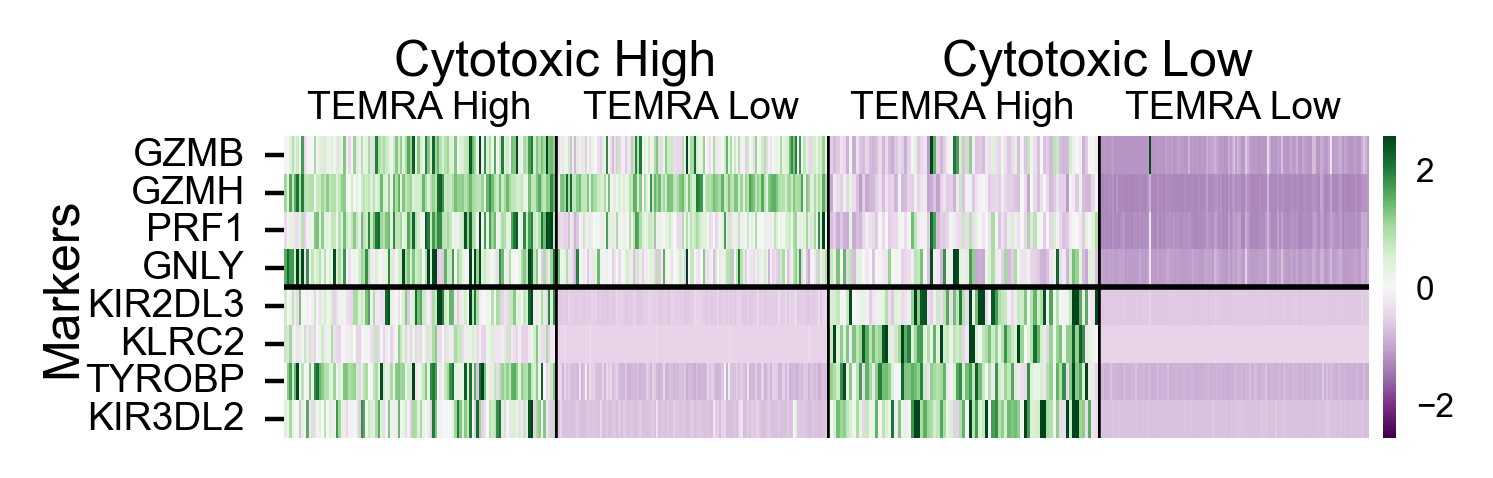

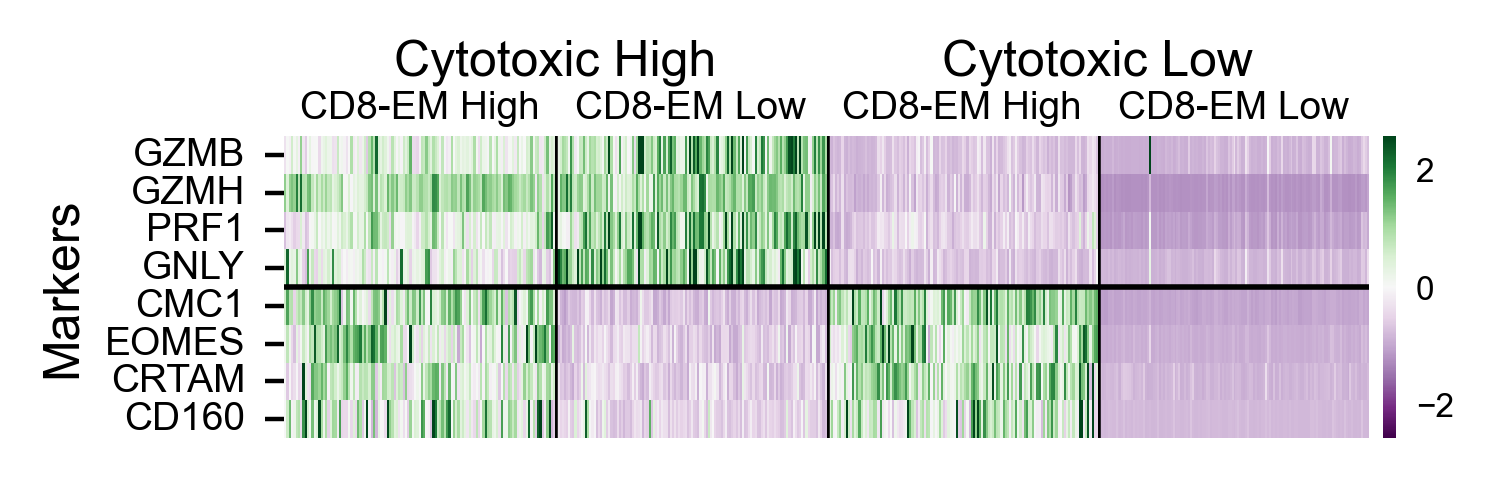

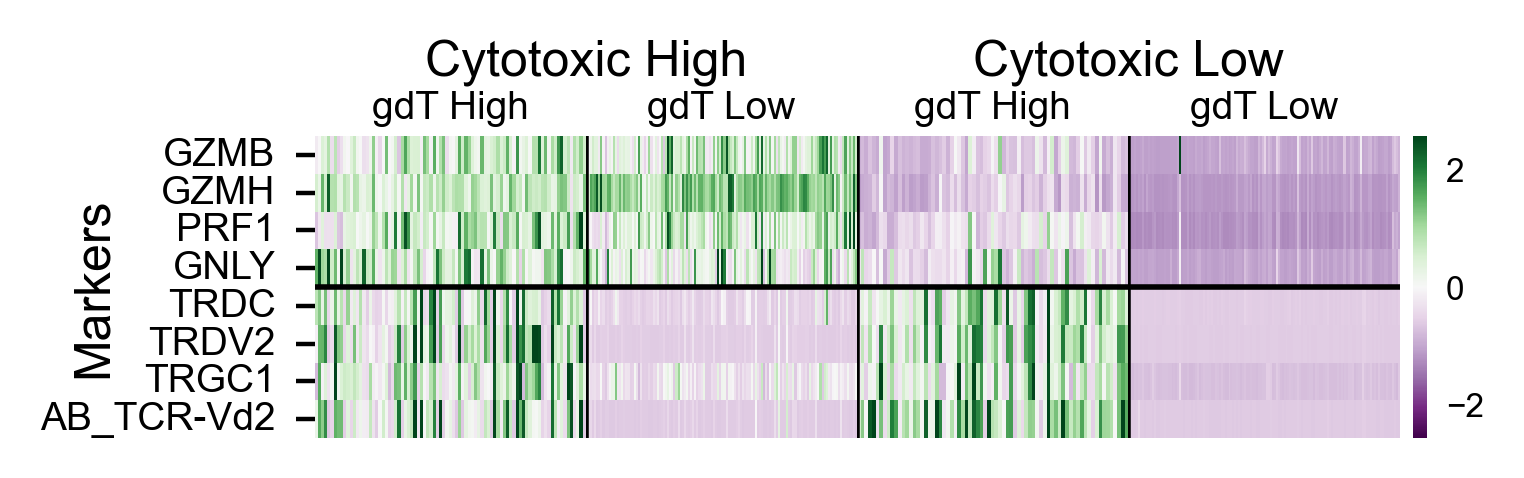

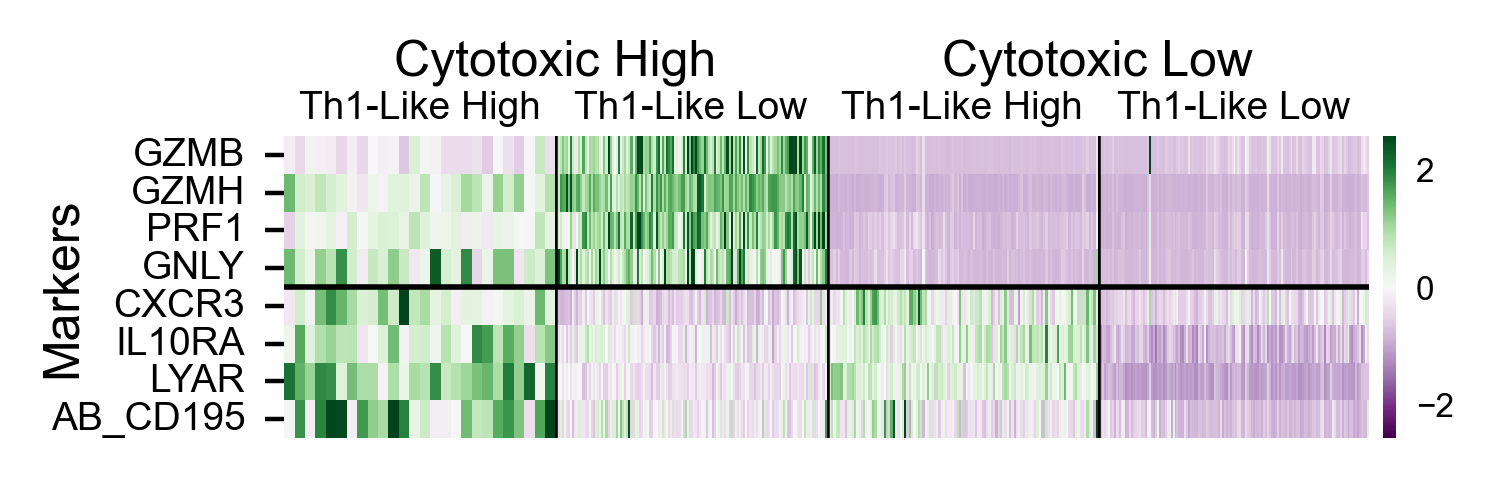

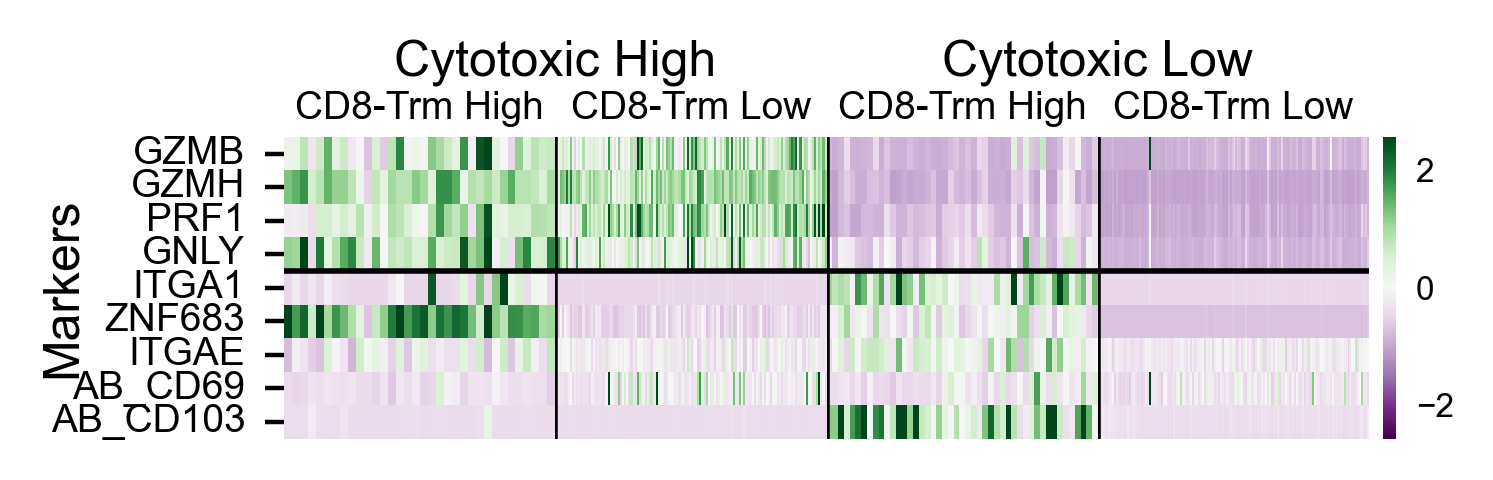

In [785]:
cbar = True
for g in gep_list:
    nrows = 1
    ncols = 4
    width = 3.5
    height = 1    
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                             dpi = 400, gridspec_kw = {'wspace' : 0
                                                      })
    # for j, g in enumerate(glist):   
    dat_all = gep_dat[g]
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna

    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt

    for class_i, class_bool in enumerate([True, False]):
        for bin_i, bin_bool in enumerate([True, False]):
            ax = axes[2*class_i + bin_i]
            # print(g, class_bool, bin_bool, 2*class_i + bin_i)


            dat = dat_all[(dat_all['Bin_%s' % g]==bin_bool) & (dat_all['Bin_Cytotoxic']==class_bool)]
            print(g, class_bool, bin_bool, 'Num Samples Filtered: %i' % dat[dat['Ncell']<min_cells].shape[0])
            dat = dat[dat['Ncell'] >= min_cells]
                        
            sns.heatmap(dat[ms].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)

            # if n==0:
            gname=g
            ax.set_title({True: '%s High' % gname, False: '%s Low' %gname}[bin_bool], 
                         y = .95, fontsize = tick_fontsize)

            if bin_i==0:
                ax.text(1, 1.2, s = {True: 'Cytotoxic High', False: 'Cytotoxic Low'}[class_bool], 
                        transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)
            ax.set_xticks([])


            ax.axhline(4, 0, 4, color = 'black', linewidth = 1)

            if (2*class_i + bin_i)!=0:
                ax.set_yticks([])
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)
            else:
                ax.set_yticks(np.arange(0.5, len(ms)), ms)
                
                ax.text(-.9, 0.5, 'Markers', rotation = 90,
                        transform=ax.transAxes, va = 'center', fontsize = label_fontsize)
                
                # ax.set_ylabel('Markers', size = label_fontsize, position=(-1,0.5))
            ax.tick_params('both', labelsize = tick_fontsize)

            # ax = axes[0]
    if cbar:

        # cax = ax.inset_axes([-.8, 1.25, .5, .1], transform=ax.transAxes)
        # cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
        #                         cmap=sns.color_palette("PRGn", as_cmap=True)),
        #              ax=ax, cax=cax, orientation='horizontal')
        # # cbar.outline.set_linewidth(0) 
        # cax.set_xticks([vmin, vmax])
        # cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
        #                      '%.1f' % vmax])
        # # cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-2)
        # cax.tick_params(labelsize=tick_fontsize-2)
        # cbar = False

        print(vmax)
        cax = ax.inset_axes([1.05, 0, .05, 1], transform=ax.transAxes)
        cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                                    cmap=sns.color_palette("PRGn", as_cmap=True)),
                     ax=ax, cax=cax, orientation='vertical')
        cbar.outline.set_linewidth(0) 
        cax.tick_params(labelsize=tick_fontsize-1, length=0)
        cbar = True

    # plt.show()

    plt.savefig(os.path.join(figdir, 'HeatmapCytotoxicMarkers_%s.COMBAT.png' % g), bbox_inches="tight")
    plt.savefig(os.path.join(figdir, 'HeatmapCytotoxicMarkers_%s.COMBAT.pdf' % g), bbox_inches="tight")

### Filtered genes - CD4/CD8 split

In [564]:
sample_order = list(X['sample'].unique())
len(sample_order)

138

In [565]:
ms_rna_dict = {
                'Th1-Like' : ['CXCR3', 'IL10RA'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
               'Treg':['FOXP3', 'IL2RA', 'CTLA4'],
                'Cytotoxic': ['GZMB', 'GZMH', 'PRF1', 'GNLY'],
               'TEMRA' : [#'FCGR3A', 'KLRF1', 'NCR1',

                'KIR2DL3',
                'KLRC2',
                'TYROBP',
                'KIR3DL2'],
               'CD8-EM' : ['CMC1','EOMES',
                    'DTHD1',
                    'CRTAM',
                    'LYST',
                    'CD160',
                    ]
    ,
               'gdT' : ['TRDC', 'TRDV2', 'TRGC1'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195'],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194'],
              'Treg' : ['AB_CD25', 'AB_CD39'],
              # 'TEMRA' : ['AB_CD45RA'],
              # 'CD8-EM' : ['AB_TIGIT', ],
               'gdT' : ['AB_TCR-Vd2']
}


In [566]:
gep_list = ['TEMRA', 'CD8-EM', 'gdT', 'Th1-Like'
            #'CD8-Trm'
           ]

In [567]:
X_test = X[(X['class'].isin(['CD4', 'CD8']))]


In [568]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []
ms_all += ms_rna_dict['Cytotoxic']
# ms_rna_all = []
# ms_adt_all = []

for g in gep_list:
    sample_sum = X_test.groupby(['sample', 'class', 'Bin_Cytotoxic', 'Bin_%s' % g]).sum().reset_index().dropna()
    sample_sum['Ncell'] = X_test.groupby(['sample','class', 'Bin_Cytotoxic', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    
    ms_rna += ms_rna_dict['Cytotoxic']
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    
    # ms_rna_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
        # ms_adt_all += ms_adt

    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    ms_cyto = ms + ms_rna_dict['Cytotoxic']
    dat_all[ms_cyto] = dat_all[ms_cyto].subtract(sample_sum[ms_cyto].mean(), axis =1)
    dat_all[ms_cyto] = dat_all[ms_cyto].divide(sample_sum[ms_cyto].std(), axis = 1)

    gep_dat[g] = dat_all
    ms_all += ms

In [569]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    dat_all = gep_dat[g]    
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.98)
vmin = -vmax

In [570]:
vmax

2.6026068544387693

In [498]:
label_fontsize = 10
tick_fontsize = 8

In [501]:
gep_list_test = [['TEMRA'], ['CD8-EM'], ['gdT'], ['Th1-Like']]

In [524]:
tick_fontsize = 6
label_fontsize = 8

In [573]:
g = 'Th1-Like'
dat_all = gep_dat[g]


In [577]:
lineage='CD8'

Th1-Like True True 0
Th1-Like True False 1
Th1-Like False True 2
Th1-Like False False 3
Th1-Like True True 0
Th1-Like True False 1
Th1-Like False True 2
Th1-Like False False 3


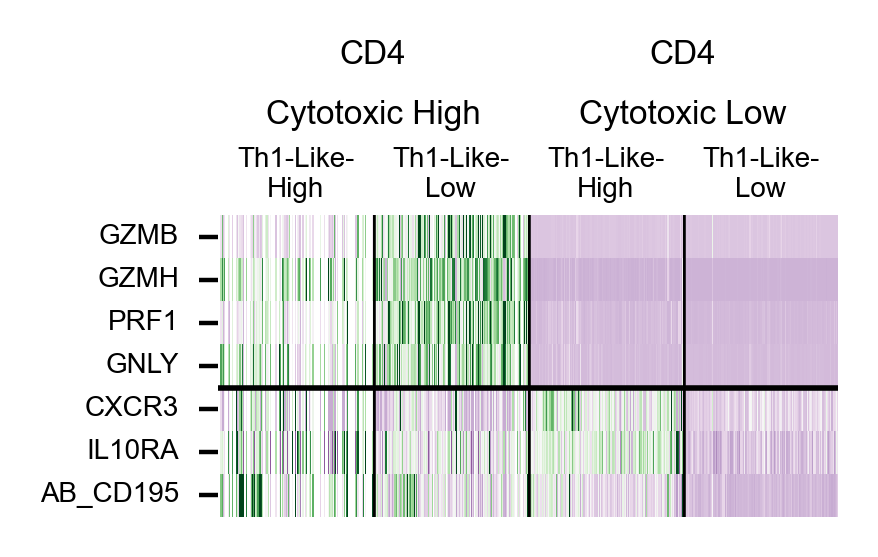

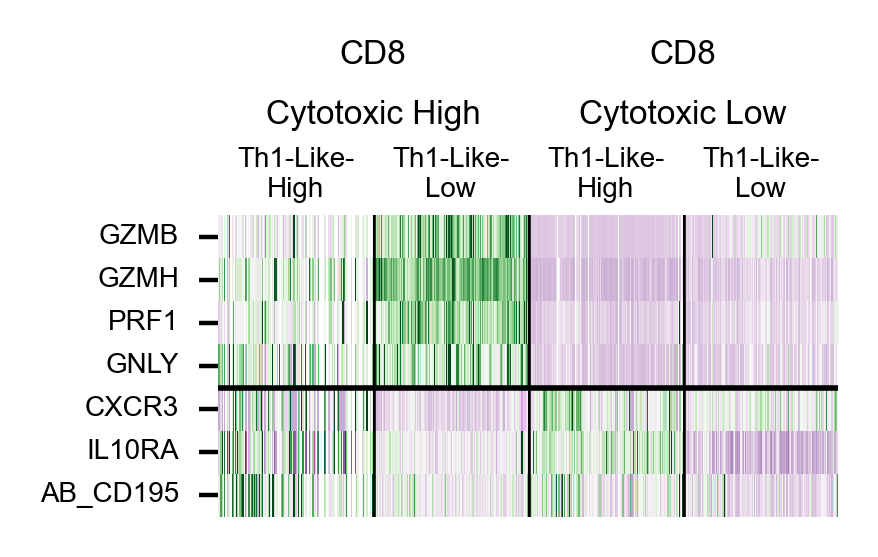

In [580]:
for lineage in ['CD4', 'CD8']:
    nrows = 1
    ncols = 4
    width = 2
    height = 1    
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                             dpi = 400, gridspec_kw = {'wspace' : 0
                                                      })
    # for j, g in enumerate(glist):   
    dat_all = gep_dat[g]
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna

    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt

    for class_i, class_bool in enumerate([True, False]):
        for bin_i, bin_bool in enumerate([True, False]):
            ax = axes[2*class_i + bin_i]
            print(g, class_bool, bin_bool, 2*class_i + bin_i)


            dat = dat_all[(dat_all['class']==lineage)&
                (dat_all['Bin_%s' % g]==bin_bool) & (dat_all['Bin_Cytotoxic']==class_bool)]
            sns.heatmap(dat[ms].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)

            # if n==0:
            gname=g
            ax.set_title({True: '%s-\nHigh' % gname, False: '%s-\nLow' %gname}[bin_bool], 
                         y = .95, fontsize = tick_fontsize-1)

            if bin_i==0:
                ax.text(1, 1.5, s = lineage, 
                        transform=ax.transAxes, ha = 'center', fontsize = tick_fontsize)

                ax.text(1, 1.3, s = {True: 'Cytotoxic High', False: 'Cytotoxic Low'}[class_bool], 
                        transform=ax.transAxes, ha = 'center', fontsize = tick_fontsize)
            ax.set_xticks([])
            ax.axhline(4, 0, 4, color = 'black', linewidth = 1)

            if (2*class_i + bin_i)!=0:
                ax.set_yticks([])
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)
            else:
                ax.set_yticks(np.arange(0.5, len(ms)), ms)
            ax.tick_params('both', labelsize = tick_fontsize-1)

    ax = axes[0]
    if cbar:
        
        cax = ax.inset_axes([-.8, 1.25, .5, .1], transform=ax.transAxes)
        cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                                cmap=sns.color_palette("PRGn", as_cmap=True)),
                     ax=ax, cax=cax, orientation='horizontal')
        # cbar.outline.set_linewidth(0) 
        cax.set_xticks([vmin, vmax])
        cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                             '%.1f' % vmax])
        # cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-2)
        cax.tick_params(labelsize=tick_fontsize-2)
        cbar = False

